<a href="https://colab.research.google.com/github/steveseguin/color-grading/blob/master/colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Free OBS LUT Maker
This tool is hosted by Google, created by Steve Seguin, and it's free to use, modify, etc. I just ask that any derivation or distribution of this code, commericial or otherwise, gives credit and link back to the github repo: https://github.com/steveseguin/color-grading

To get the code started, we are going to need to import the needed Python libraries: these empower us to do matrix manipulation, computer vision, and machine learning.

In [0]:
import cv2 #  computer vision
from google.colab.patches import cv2_imshow

import numpy as np # matrix math
from matplotlib import pyplot as plt # Plotting software to help us visualize some things

from sklearn.preprocessing import PolynomialFeatures  # making math equations
from sklearn.linear_model import LinearRegression 
from sklearn.metrics import mean_squared_error, r2_score # solving math equations

import warnings
warnings.filterwarnings("ignore")  # hides some warnings 

Let's create our digital color reference chart. This needs to be based on your physical color reference chart's RGB values.

I went to the local paint store and picked up free paper color samples to make my color chart. At a minimum, you will need WHITE, GREY, and BLACK samples. Adding other colors will help, but are not needed. I picked 9 colors total.

<img src="https://raw.githubusercontent.com/steveseguin/color-grading/master/Image2.png" width="200"/>

If you pick up Behr-branded color samples, you can reference their online website for the RGB values of the colors. ie: https://www.behr.ca/consumer/colors/paint/color/MQ1-02

You can order professional color reference samples as well, such as https://www.amazon.com/Datacolor-SCK200-SpyderCHECKR-24/dp/B00LPS46TW

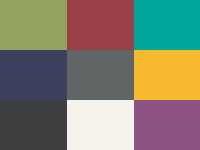

In [3]:
total_rows = 3  # Change to the number of rows in your color chart
total_columns = 3 # Change to the number of columns in your color chart

# Update the follow values with your RGB values.
right = [[147,163,96],[154,64,73],[0,166,153],
		[61,65,93],[96,102,102],[247,185,48],
		[62,63,64],[245,243,236],[138,83,129]] ## [[RGB],[RGB],...[RGB]]  Modify with the RGB values of each color, in the order that you read a book

#R: 0 G: 166 B: 153
#R: 154 G: 64 B: 73
#R: 61 G: 65 B: 93
#R: 247 G: 185 B: 48
#R: 245 G: 243 B: 236
#R: 138 G: 83 B: 129
test = np.array(right).reshape((total_rows,total_columns,3)).astype("uint8") 
test = cv2.cvtColor(test, cv2.COLOR_RGB2BGR)
test = cv2.resize(test,(200,150),interpolation=cv2.INTER_NEAREST)
cv2_imshow(test) ## If the colors don't match, something is wrong. This is our color target for the output

wrong = np.zeros_like(right) 

Below, let's take a photo of our our color reference chart taken with our camera under the lighting conditions we wish to create our OBS-LUT for and upload it to this script.

Image size doesn't matter a whole lot, but make sure the is cropped to fit the image.

Hit Cancel Upload if you want to use the default demo image instead.

Example Image to upload:

<img src="https://raw.githubusercontent.com/steveseguin/color-grading/master/Image1.png" width="200"/>

Saving logcrop.jpg to logcrop.jpg
User uploaded file "logcrop.jpg" with length 23917 bytes


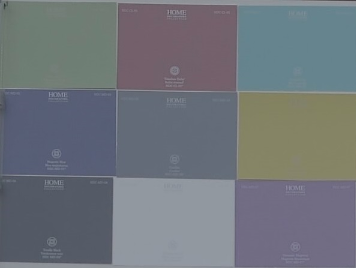

In [5]:
from google.colab import files # lets us upload images to Google Colab from local storage
uploaded = files.upload()
img_file = None

for fn in uploaded.keys():  ## 
  print('User uploaded file "{name}" with length {length} bytes'.format(name=fn, length=len(uploaded[fn])))
  img_file = fn
  
if (img_file==None): ## If no image is uploaded by user
  !wget https://raw.githubusercontent.com/steveseguin/color-grading/master/logcrop.jpg -O drive/images/logcrop.jpg  # DOWNLOAD SAMPLE IMAGE
  img_file = "drive/images/logcrop.jpg"
    
img = cv2.imread(img_file, 1) # LOAD INTO PYTHON
w,h,_ = np.shape(img) # GET SIZE OF IMAGE
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # CONVERT FROM BGR to RGB (OPENCV defaults to BGR for some reason?)

cv2_imshow(cv2.cvtColor(cv2.resize(img,None,fx=0.6,fy=0.6), cv2.COLOR_RGB2BGR)) 

## You may need to re-run this code block a second time if you get an error the first time

We are going to go threw all the colors in the image of the color chart and get the RGB colors from it. 

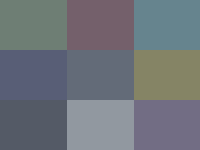

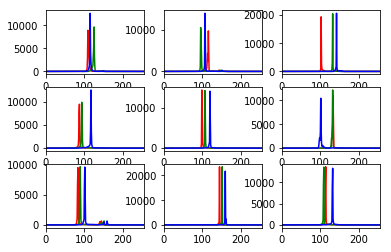

In [6]:

color = ('r','g','b')
for x in range(total_rows):
	for y in range(total_columns):
		for i,col in enumerate(color):
			seg = img[int(x*w/3):int((x+1)*w/3),int(y*h/3):int((y+1)*h/3),:] # We assume each color block is the same size and that the image is cropped correctly
			histr = cv2.calcHist([seg],[i],None,[256],[0,256]) # Create a histogram
			j = x*3+y+1
			wrong[j-1][i]=np.where(np.max(histr)==histr)[0][0] # What is the PEAK color for each block? use this rather than the average RGB value.
			plt.subplot(3,3,j)
			plt.plot(histr,color = col) # Plot, so you can se what's going on.
			plt.xlim([0,256])
			
 # If successful, you should see some plots below. Each plot should have 1 blue, 1 red, and 1 green peak each. 
test = np.array(wrong).reshape((total_rows,total_columns,3)).astype("uint8") 
test = cv2.cvtColor(test, cv2.COLOR_RGB2BGR)
test = cv2.resize(test,(200,150),interpolation=cv2.INTER_NEAREST)
cv2_imshow(test)  ## THIS IS WHAT THE INPUT IT IS; confirm it matches the photo you uploaded.

## We will want to do the learning step in HSV-colour space instead of RGB.
#wrong_HSV = cv2.cvtColor(np.array(wrong).reshape((total_rows,total_columns,3)).astype("uint8"), cv2.COLOR_RGB2HSV).reshape((-1))
#right_HSV = cv2.cvtColor(np.array(right).reshape((total_rows,total_columns,3)).astype("uint8"), cv2.COLOR_RGB2HSV).reshape((-1))

This next step we are essentially trying to solve a mathematical optimization equation; it will give us our optimized colour-correcting transformation. 

The Basic Logic that we are doing is the following:

```y = a*x^2 + b*x + c ``` , a Polynomial Curve applied to Input Image as a color-transformation

```y1 = (y0 - y)```  , We want the input image to match the target image, or as close as possible.

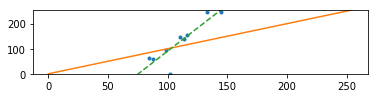

R error: 37.38192869961481
	 ^ High number implies result is not that optimized


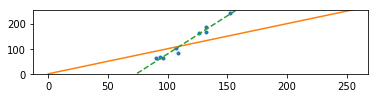

G error: 10.655860494993608


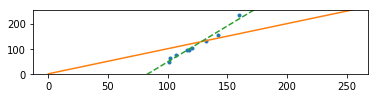

B error: 9.440160572516575


In [65]:
poly={}
colors = ["R","G","B"]
xp = np.linspace(0, 255, 255)
for rgb in range(3):
  www = np.ravel(wrong)[rgb::3]
  rrr = np.ravel(right)[rgb::3]
  poly[rgb] = np.polyfit(www, rrr, 1) ## you can play with the number of polynominals, but more can lead to overfitting. The most you want to try is probably 2
  p = np.poly1d(poly[rgb])
  delta = rrr - p(www)
  power = np.power(delta,2)
  mean = np.mean(power)
  final = np.sqrt(mean)
  plt.subplot(3,1,rgb+1)
  _ = plt.plot(www, rrr, '.', xp, xp, '-', xp, p(xp), '--')
  plt.ylim(0,255)
  plt.show()
  print(colors[rgb],"error:",final)
  if (final>30):
     print("\t ^ High number implies result is not that optimized")


We now want to upload an image that we want to colour-correct. This step is optional, but it will let us confirm how well things worked before creating our final OBS-LUT image.

Hit Cancel Upload to use the provided sample image.

Saving log.jpg to log (2).jpg
User uploaded file "log.jpg" with length 1123880 bytes


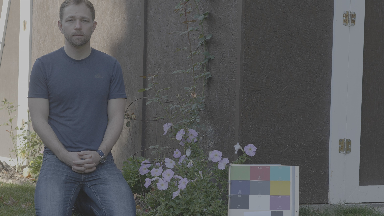

Dynamic range: 14 - 219


In [66]:
from google.colab import files # lets us upload images to Google Colab from local storage
uploaded = files.upload()
img_file = None

for fn in uploaded.keys():  ## 
  print('User uploaded file "{name}" with length {length} bytes'.format(name=fn, length=len(uploaded[fn])))
  img_file = fn
  
if (img_file==None): ## If no image is uploaded by user
  !wget https://raw.githubusercontent.com/steveseguin/color-grading/master/log.jpg -O drive/images/log.jpg  # DOWNLOAD SAMPLE IMAGE
  img_file = "drive/images/log.jpg"

img2 = cv2.imread(img_file, 1)	

cv2_imshow(cv2.resize(img2,None,fx=0.1,fy=0.1))
print("Dynamic range:",np.min(img2),"-",np.max(img2))

img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
img2 = img2.astype(np.float32, copy=False)

# YOU MAY NEED TO RUN THIS TWICE FOR IT TO WORK

PRE range: 16.0 - 219.0
POST range: -218.5198 - 528.4526
PRE range: 21.0 - 219.0
POST range: -160.17593 - 440.49023
PRE range: 14.0 - 219.0
POST range: -198.93716 - 388.315

Consider shooting with more contrast or less dynamic range to get less colour banding


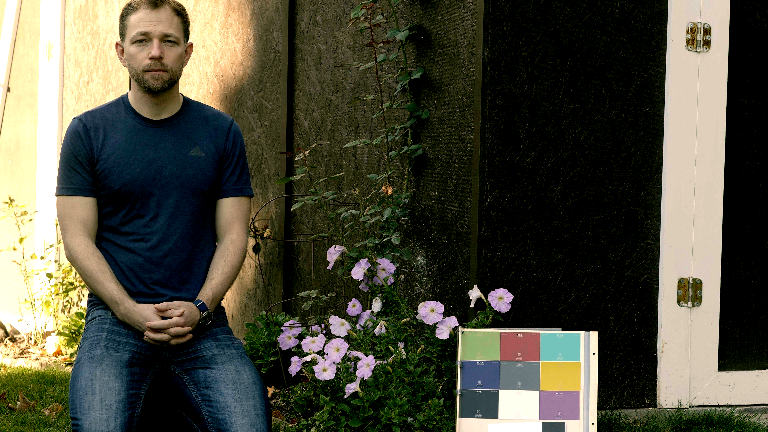

In [71]:
def applyLUT(image):
  assert(image.dtype == "float32")
  for rgb in range(3):
    p = np.poly1d(poly[rgb])
    print("PRE range:",np.min(image[:,:,rgb]),"-",np.max(image[:,:,rgb]))
    image[:,:,rgb] = p(image[:,:,rgb])
    print("POST range:",np.min(image[:,:,rgb]),"-",np.max(image[:,:,rgb]))
  return image

img = np.zeros_like(img2)
img[:] = img2[:]

## BRIGHTNESS ADJUSTMENT. 
mb = 20   #  -20 to 20 is a good range to try; 0 is default
img = applyLUT(img) + mb

#print("Dynamic range:",np.min(img),"-",np.max(img))
print()
if ((np.min(img)>25) & (np.max(img)<230)):
  print("Consider shooting in LOG or reducing contrast on your camera when recording")
elif (np.min(img)>25):
  print("Consider capturing with reduced exposure to capture more shadow detail")
elif (np.max(img)<230):
  print("Consider capturing with increase exposure to capture more highlight detail")
elif ((np.min(img)<-300) or (np.max(img)>500)):
  print("Consider shooting with more contrast or less dynamic range to get less colour banding")
  
test = np.zeros_like(img)
test[:] = img
test[np.where(test>255)]=255 # cut out bad highlights
test[np.where(test<0)]=0 # cut out bad shadows
test = test.astype(np.uint8, copy=False)

cv2_imshow(cv2.cvtColor(cv2.resize(test,None,fx=0.2,fy=0.2), cv2.COLOR_RGB2BGR))

We will want to add a gentle roll-off at the black/white extremes when color correction is complete; this lets us to keep details in some highlights and shadows. When RGB > 225 or RGB < 30, we will refer to these Look-Up Tables to see how to best increase the dynamic range.

To see the Gamme Curve applied, see here
https://www.desmos.com/calculator/85cadg5cfx

In [0]:

LUT2 = np.zeros((492)) # LIGHT
for y in range(22500,25500):
    x = int(round((y/100-225)/1 + 1/(1.2**(225-y/100))+225))
    LUT2[x-226] = int(round(y/100.0))
LUT1 = 255-np.flip(LUT2)  # DARK

Applying the Gamma Curve to the Image. Optional, but recommended

Dynamic range: 1.0 - 548.4526


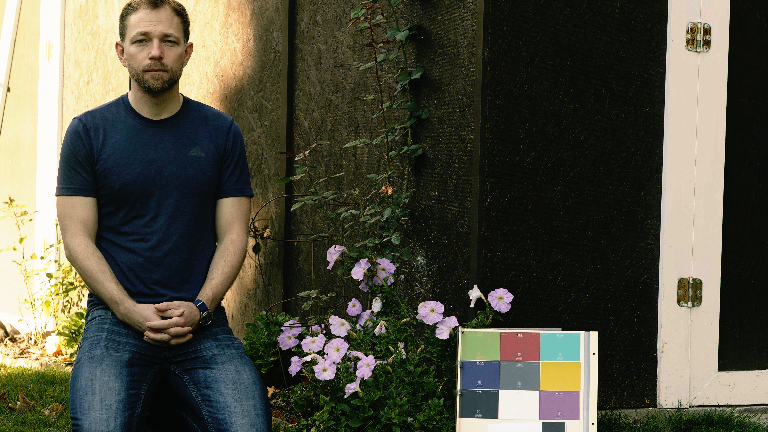

In [69]:

where = np.where((img>225) &(img<492))
out = LUT2[np.uint16(np.round(img[where]-225))]
#print(np.shape(LUT2))
img[where] = out
#print(np.shape(where))
#print(LUT1) ## INPUT+120 = LUTINDEX; max INPUT 25; min -94 ?
where = np.where((img<=30) & (img>-461))
out = LUT1[np.uint16(np.round(img[where]+461))]
#print(out)
img[where] = out

print("Dynamic range:",np.min(img),"-",np.max(img))

test = np.zeros_like(img)
test[:] = img[:]
test[np.where(test>255)]=255 # cut out highlights
test[np.where(test<0)]=0
test = test.astype(np.uint8, copy=False)

cv2_imshow(cv2.cvtColor(cv2.resize(test,None,fx=0.2,fy=0.2), cv2.COLOR_RGB2BGR))

The next step commits the Final Result in our sample image.

Data contained in highlights and shadows that isn't between 0-255 gets clipped to 0 or 255.

Dynamic range: 0 - 255 , Average Lumin Value: 6.284364605348596


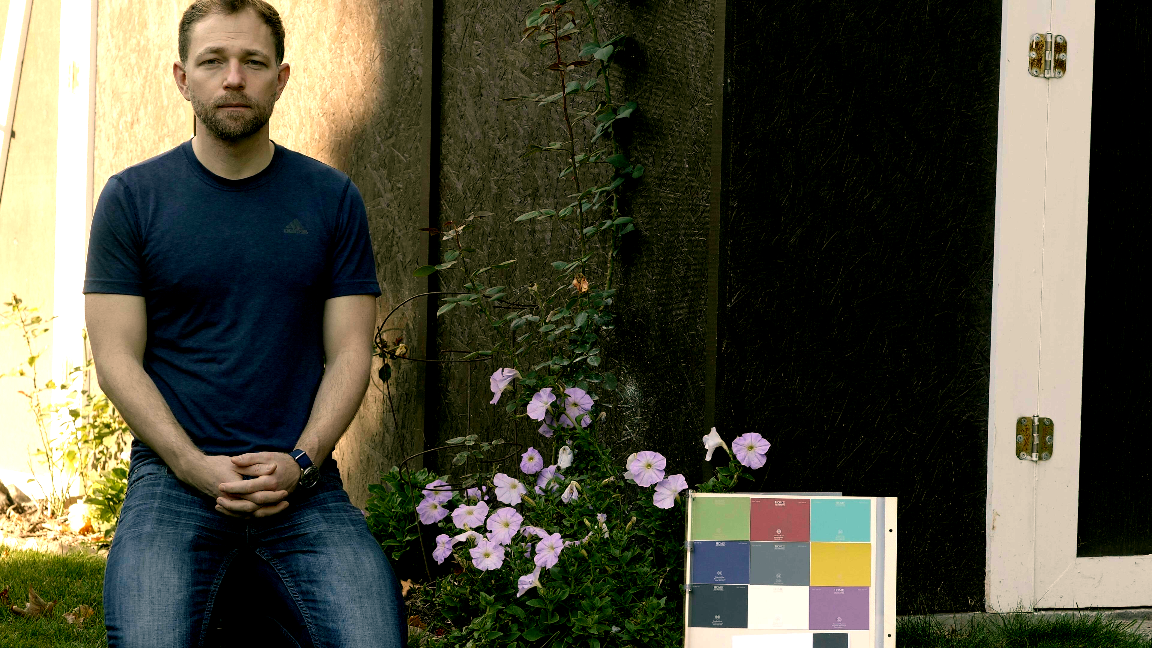

In [72]:

img[np.where(img>255)]=255 # cut out highlights
img[np.where(img<0)]=0
img = img.astype(np.uint8, copy=False)
avglum = np.mean(np.sqrt( 0.299*img[:,:,0]**2 + 0.587*img[:,:,1]**2 + 0.114*img[:,:,2]**2 ))
print("Dynamic range:",np.min(img),"-",np.max(img), ", Average Lumin Value:",avglum)
cv2_imshow(cv2.cvtColor(cv2.resize(img,None,fx=0.3,fy=0.3), cv2.COLOR_RGB2BGR))


And Finally, we generate our OBS LUT as a PNG file. Right click it once generated to save and download.

In [74]:
!wget https://raw.githubusercontent.com/steveseguin/color-grading/master/neutral-lut.png -O drive/images/neutral-lut.png  # DOWNLOAD SAMPLE IMAGE
img_file = "drive/images/neutral-lut.png"

# LOAD INTO PYTHON
lutimg = cv2.imread(img_file, 1) 
lutimg = cv2.cvtColor(lutimg, cv2.COLOR_BGR2HSV)

## ANALYTICS
avglum = np.mean(np.sqrt( 0.299*lutimg[:,:,0]**2 + 0.587*lutimg[:,:,1]**2 + 0.114*lutimg[:,:,2]**2 ))  # via: https://stackoverflow.com/questions/596216/formula-to-determine-brightness-of-rgb-color
print("PRE PROCESSING - Dynamic range:",np.min(lutimg),"-",np.max(lutimg), ", Average Lumin Value:",avglum)

lutimg = lutimg.astype(np.float32, copy=False)

## If we want to increase the brightness
# We will use what was set earlier if not defined below
# mb = 0

## APPLY THE COLOR CORRECTION
lutimg = applyLUT(lutimg) 

## APPLY HIGHLIGHT GAMMA CURVE
where = np.where((lutimg>225) &(lutimg<492))
out = LUT2[np.uint16(np.round(lutimg[where]-225))]
lutimg[where] = out

## APPLY SHADOW GAMMA CURVE
where = np.where((lutimg<=30) & (lutimg>-461))  
out = LUT1[np.uint16(np.round(lutimg[where]+461))]
lutimg[where] = out

## CLEAN UP OUT-OF-BOUNDS DATA
lutimg[np.where(img>255)]=255 # cut out bad highlights
lutimg[np.where(img<0)]=0 # cut out bad shadows
lutimg = lutimg.astype(np.uint8, copy=False)

## ANALYTICS
avglum = np.mean(np.sqrt( 0.299*lutimg[:,:,0]**2 + 0.587*lutimg[:,:,1]**2 + 0.114*lutimg[:,:,2]**2 ))  # via: https://stackoverflow.com/questions/596216/formula-to-determine-brightness-of-rgb-color
print("POST-PROCESSING - Dynamic range:",np.min(lutimg),"-",np.max(lutimg), ", Average Lumin Value:",avglum)

## GENERATE
cv2_imshow(cv2.cvtColor(lutimg,cv2.COLOR_HSV2BGR)) 

print("RIGHT CLICK IMAGE AND SELECT 'SAVE IMAGE AS' TO SAVE")


drive/images/neutral-lut.png: No such file or directory


error: ignored

Based on our sample test data, our results show that our OBS-LUT has a Dynamic range of 17 to 253. While the highlights are well calibrated, the shadows may come out looking a bit too bright. 

We can adjust this in OBS, perhaps by increasing contrast, but that may lead to increased color banding. Another option could be to adjust your camera settings to capture more shadow details, perhaps by increasing dynamic range or slightly lowering exposure, and then go thru all these steps again to generate a new LUT.

<img src="https://raw.githubusercontent.com/steveseguin/color-grading/master/obs-layout.jpg" width="700"/>

Another option, if OBS is not something you use, and you would just like to apply such a LUT to a static video file you have, you can modify the above code to work with video files.

The benefit of this approach is that the LUT used wouldnt not be bound by 0-255; but rather -250 to +450, so less data would be lost within the highlights and shadows.

Please see my github repo for this code for Python scripts for a downloadable version of these scripts that you can try to apply on videos. 
I wouldnt recommend this however unless you are a Python programmer or are willing to cough up a lot of cash to get me to continue working on it for you.



Cheers!

-steve